In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import SCCircuit
from dsn.util.dsn_util import get_savedir, get_system_from_template, get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot, plot_var_ellipse, plot_target_ellipse
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
import os



In [2]:
os.chdir('../../')

In [9]:
EPS = 1e-16

#ps = [0.9]
ps = [0.5, 0.9, 1.0]
inact_str = "NI"

dirstr = 'SC_WTA_%s/' % inact_str

# normalizing flow layer architecture
flow_type = 'PlanarFlow'
# number of layers
nlayers = 10
mult_and_shift = 'post'

lr_order = -3

In [10]:
# multivariate normal initialization variance
c_init_ords = np.array([2, 4])
sigma_inits = np.array([1.0])
start_rs = 1
num_rs = 5
random_seeds = np.arange(start_rs, num_rs+start_rs)

In [11]:
best_models = []
ME_its = []

alpha=0.05
frac_samps=0.5
std = 0.05
var = 0.05**2
               
for p in ps:

    param_dict = {
        "behavior_type":"WTA",
        "p":p,
        "var":var,
        "inact_str":inact_str,
    }
    system = get_system_from_template('SCCircuit', param_dict)

    arch_dict = {'K': 1, \
                 'D':system.D, \
                 'post_affine':True, \
                 'flow_type':flow_type, \
                 'repeats':nlayers}
    
    ptol = 0.02
    contol = 0.05
    if (p==1.0):
        tol = np.array([ptol, ptol, ptol, ptol, contol, contol, contol, contol])
        tol_inds = [0,1,2,3,4,5,6,7]
    else:
        tol = contol*np.ones((4,))
        tol_inds = [4,5,6,7]

    conv_dict = {
        'alpha':alpha,
        'frac_samples':frac_samps,
        'tol':tol,
        'tol_inds':tol_inds
    }
    print('p', p)
    best_model, max_ME, ME_it, first_it = get_ME_model(system, arch_dict, c_init_ords, 
                                                       sigma_inits, random_seeds, dirstr, 
                                                       conv_dict)
    print(max_ME, ME_it, first_it)
    best_models.append(best_model)
    ME_its.append(ME_it)

p 0.5
0 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=2_rs=1/
1 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=2_rs=2/
2 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=2_rs=3/
3 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=2_rs=4/
4 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=2_rs=5/
5 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=4_rs=1/
6 models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00

In [12]:
print(best_models)
print(ME_its)

['models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=5.00E-01_5.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=2_rs=3/', 'models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=9.00E-01_9.00E-01_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=4_rs=2/', 'models/SC_WTA_NI//SCCircuit_D=8_WTA_mu=1.00E+00_1.00E+00_2.50E-03_2.50E-03_0.00E+00_0.00E+00_1.00E+00_1.00E+00_flow=10P_M_A_sigma=1.00_c=4_rs=2/']
[array(10), array(37), array(26)]


0
dist (300, 8)
1
dist (300, 8)
2
dist (300, 8)


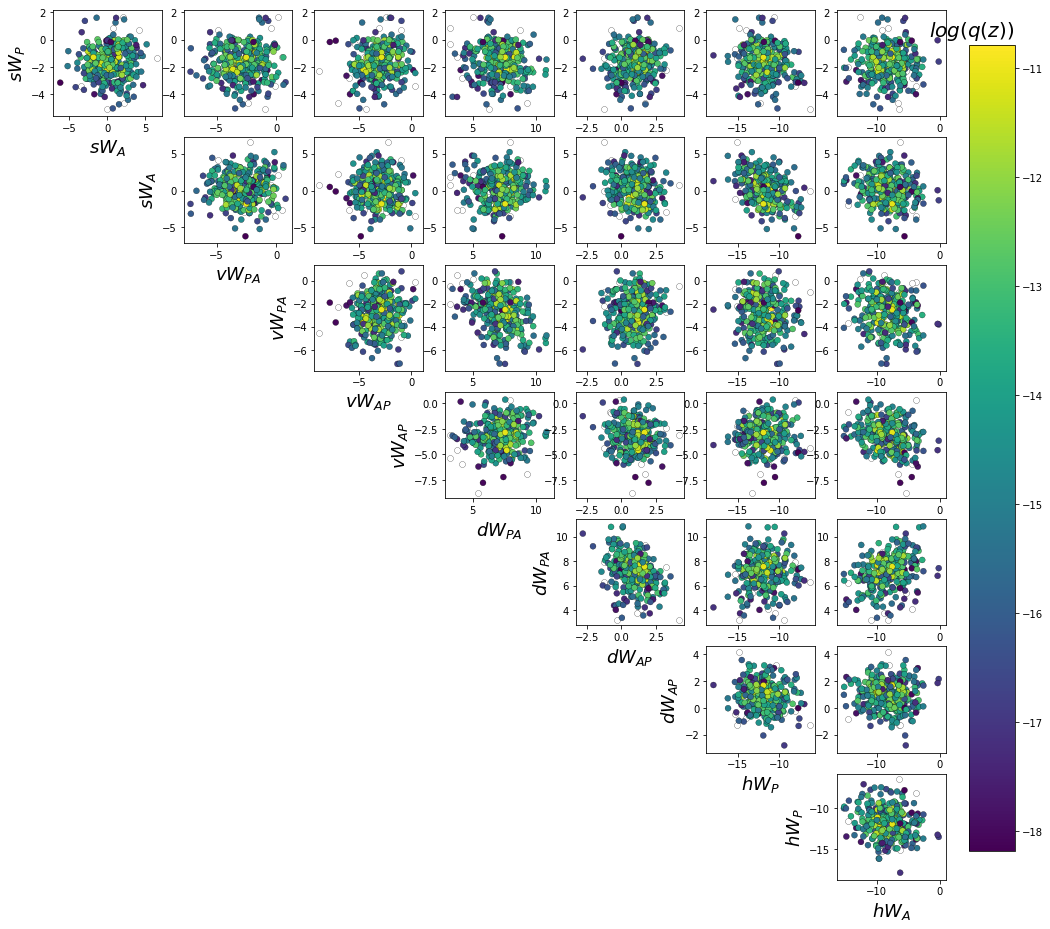

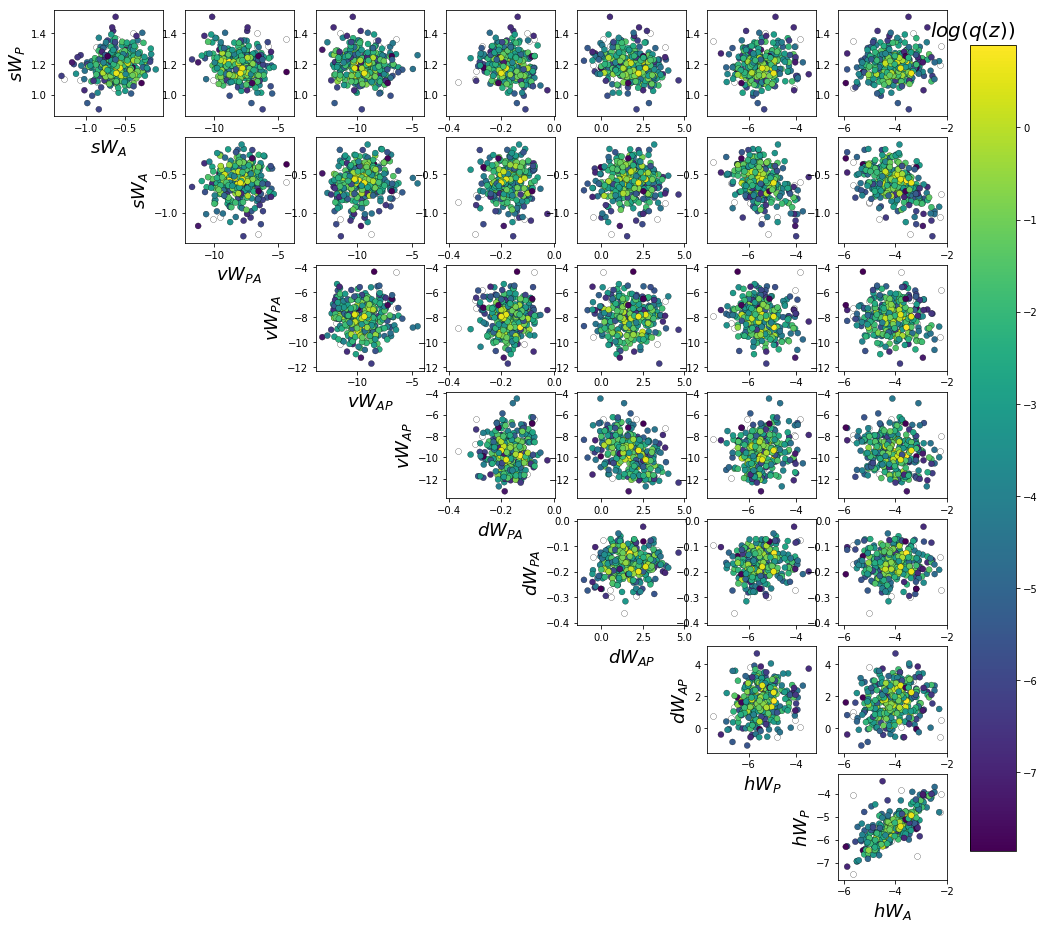

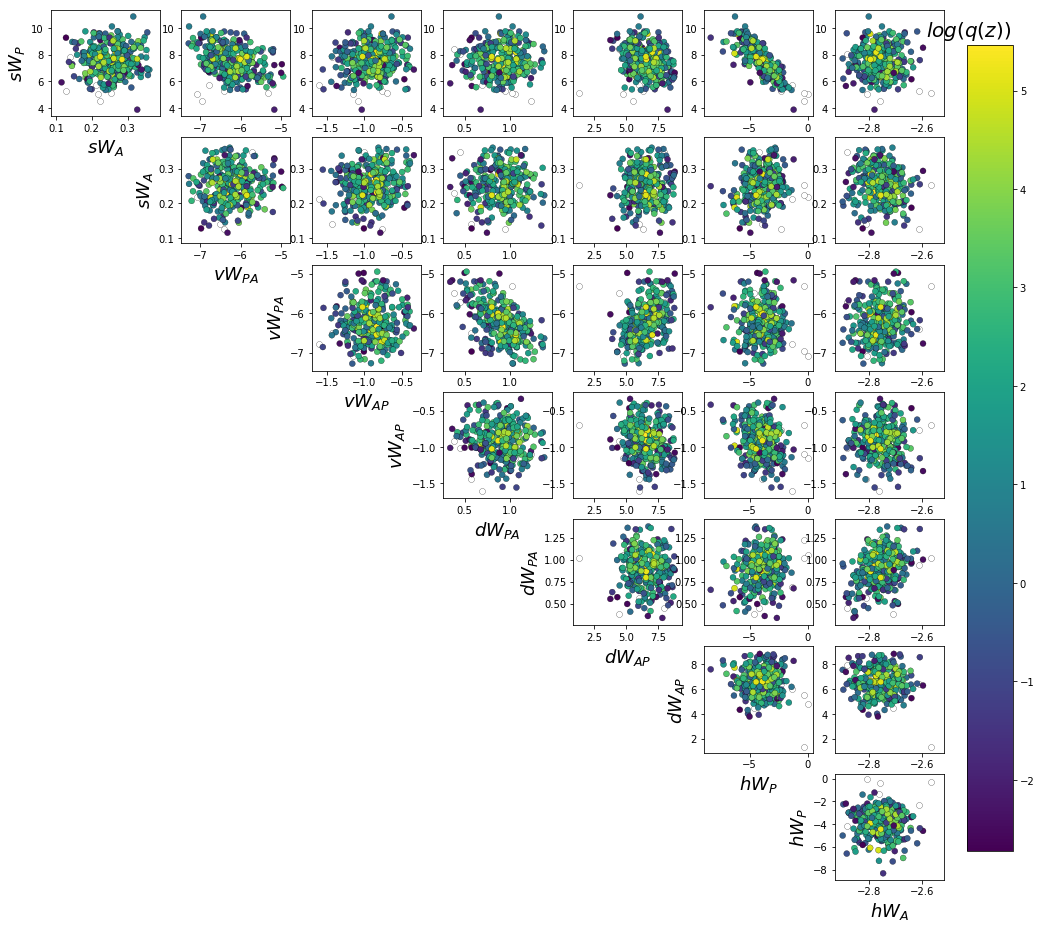

In [13]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
dists, cs, axs = dsn_pairplots(best_models, 'Zs', system, system.D, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=ME_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(16,16))


0
dist (300, 8)
1
dist (300, 8)
2
dist (300, 8)


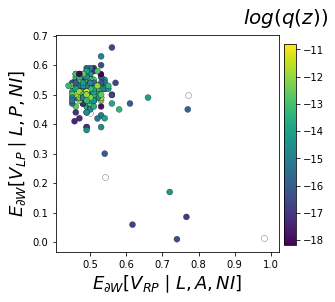

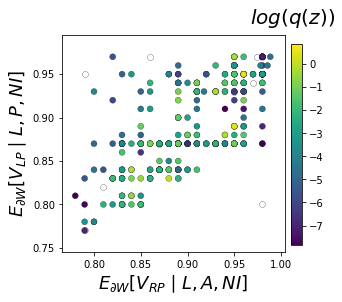

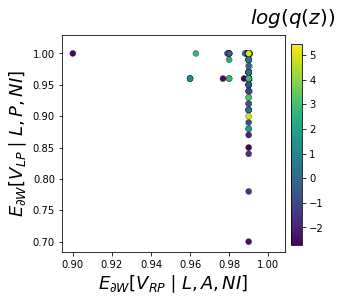

In [14]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
_, cs, axs = dsn_pairplots(best_models, 'T_xs', system, 2, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=ME_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(4,4))


In [15]:
num_ps = len(ps)
min_vals = np.zeros((num_ps, system.D,))
max_vals = np.zeros((num_ps, system.D,))

for i in range(num_ps):
    min_vals[i] = np.min(dists[i], 0)
    max_vals[i] = np.max(dists[i], 0)
min_vals = np.min(min_vals, 0)
max_vals = np.max(max_vals, 0)
print(min_vals)
print(max_vals)

[ -5.08846916  -6.19043737 -11.71241705 -13.15440163  -0.36269538
  -2.80458603 -17.91774533 -15.25862338]
[ 1.08588243e+01  6.54706263e+00  7.90291072e-01  3.75694627e-01
  1.08273326e+01  8.80471641e+00 -1.02225613e-02 -1.28293684e-01]


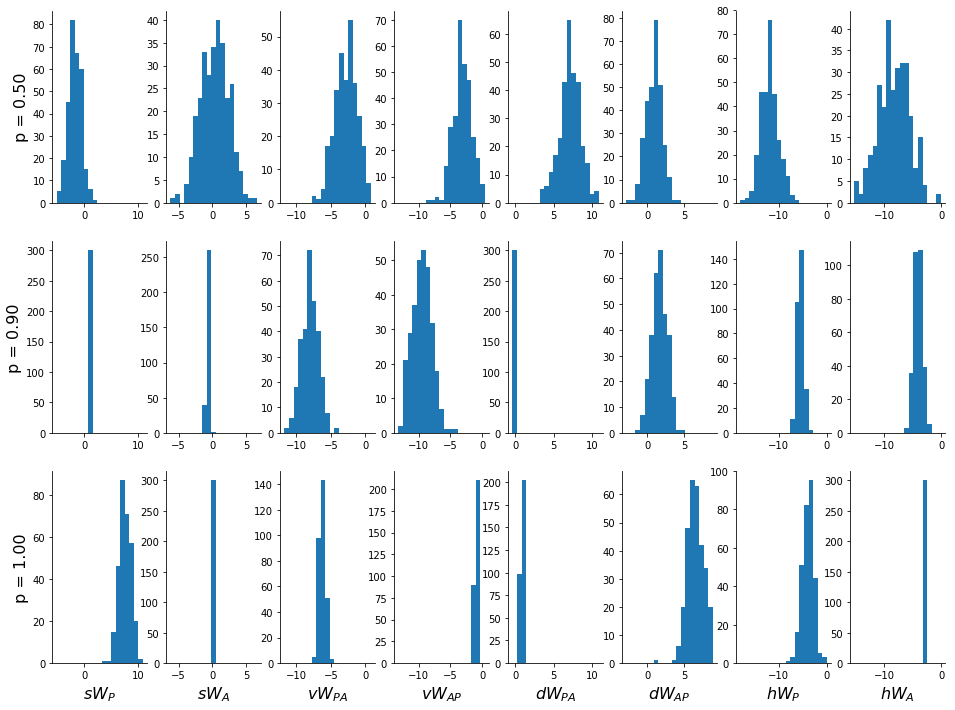

In [16]:
fontsize = 16
fig, axs = plt.subplots(num_ps, system.D, figsize=(16, 12))

for i in range(num_ps):
    for j in range(system.D):
        axs[i][j].hist(dists[i][:,j], bins=np.linspace(min_vals[j], max_vals[j], 20))
        #axs[i][j].set_xlim([min_vals[j], max_vals[j]])
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        
for i in range(num_ps):
    axs[i][0].set_ylabel('p = %.2f' % ps[i], fontsize=fontsize)
    
for i in range(system.D):
    axs[-1][i].set_xlabel(system.z_labels[i], fontsize=fontsize)   
plt.show()

In [17]:
DTYPE = tf.float64
Z = tf.placeholder(dtype=DTYPE, shape=(1,None,system.D))
W, I, eta = system.filter_Z(Z)
_Ws = []
with tf.Session() as sess:
    for i in range(len(ps)):
        _Z = np.expand_dims(dists[i], 0)
        _Ws.append(sess.run(W, {Z:_Z}))

In [18]:
def get_schur_eigs(W):
    # returns 
    T, Z = scipy.linalg.schur(W)
    b = Z.copy()
    b[b<0.0] = -1
    b[b>0.0] = 1
    modes = 0.25*np.array([[1.0, 1.0, 1.0, 1.0],   # all mode
                          [-1.0, -1.0, 1.0, 1.0], # side mode
                          [1.0, -1.0, -1.0, 1.0], # task mode
                          [-1.0, 1.0, -1.0, 1.0]]) # diag mode
    X = np.abs(np.dot(modes,b))  # (template_mode x z_col)
    eigs = np.zeros((4,))
    for i in range(4):
        z_ind = np.argmax(X[i] == 1.0)
        eigs[i] = T[z_ind, z_ind]
    return eigs
    

In [19]:
M = 300
eigs = []
for i in range(len(ps)):
    e = np.zeros((M, 4))
    for j in range(M):
        e[j] = get_schur_eigs(_Ws[i][0,j,:,:])
    eigs.append(e)


In [20]:
num_ps = len(ps)
min_vals = np.zeros((num_ps, 4,))
max_vals = np.zeros((num_ps, 4,))

for i in range(num_ps):
    min_vals[i] = np.min(eigs[i], 0)
    max_vals[i] = np.max(eigs[i], 0)
min_vals = np.min(min_vals, 0)
max_vals = np.max(max_vals, 0)

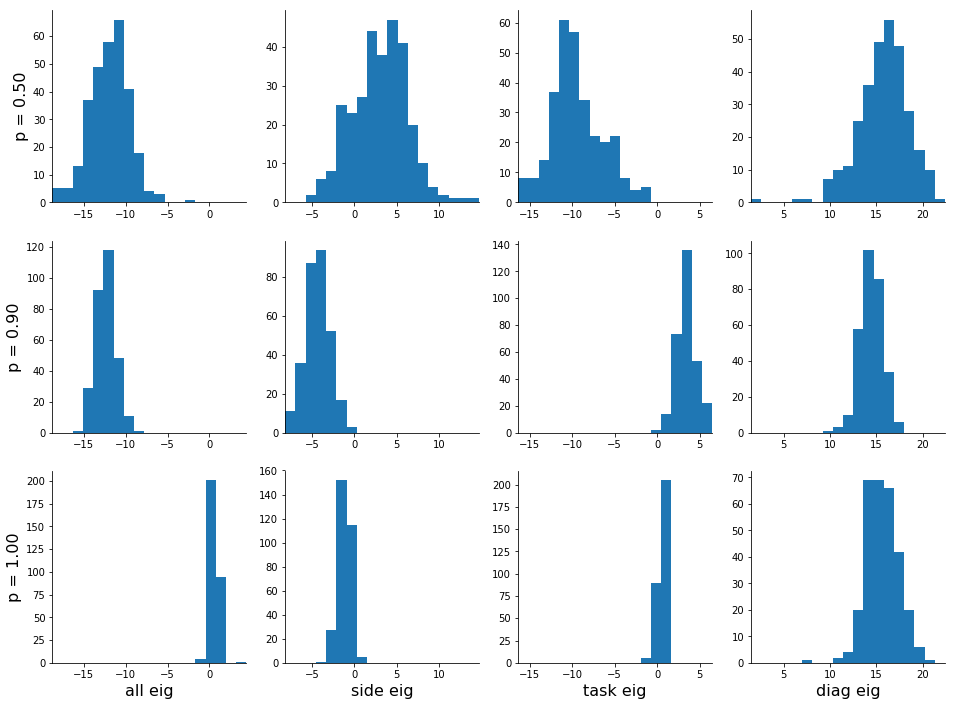

In [21]:
fontsize = 16
fig, axs = plt.subplots(num_ps, 4, figsize=(16, 12))

for i in range(num_ps):
    for j in range(4):
        axs[i][j].hist(eigs[i][:,j], bins=np.linspace(min_vals[j], max_vals[j], 20))
        axs[i][j].set_xlim([min_vals[j], max_vals[j]])
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        
for i in range(num_ps):
    axs[i][0].set_ylabel('p = %.2f' % ps[i], fontsize=fontsize)
    
schur_mode_labels = ["all eig",
                     "side eig",
                    "task eig",
                    "diag eig"]
for i in range(4):
    axs[-1][i].set_xlabel(schur_mode_labels[i], fontsize=fontsize)   
plt.show()

In [22]:
print(eigs[0].shape)
for i in range(len(ps)):
    print('p = %.2f' % ps[i])
    print('all mode %.1f%% positive' % (100*np.sum(eigs[i][:,0] > 0.0) / M))
    print('side mode %.1f%% positive' % (100*np.sum(eigs[i][:,1] > 0.0) / M))
    print('task mode %.1f%% positive' % (100*np.sum(eigs[i][:,2] > 0.0) / M))
    print('diag mode %.1f%% positive' % (100*np.sum(eigs[i][:,3] > 0.0) / M))
    print('')

(300, 4)
p = 0.50
all mode 0.0% positive
side mode 81.3% positive
task mode 0.0% positive
diag mode 100.0% positive

p = 0.90
all mode 0.0% positive
side mode 0.0% positive
task mode 99.3% positive
diag mode 100.0% positive

p = 1.00
all mode 93.0% positive
side mode 5.0% positive
task mode 92.7% positive
diag mode 100.0% positive



In [23]:
print(eigs[0].shape)
modes = ['all', 'side', 'task', 'diag']
for j in range(4):
    percs = []
    for i in range(len(ps)):
        percs.append(100*np.sum(eigs[i][:,j] > 0.0) / M)
    print('%s mode %.1f%% positive' % (modes[j], sum(percs)/len(ps)))

(300, 4)
all mode 31.0% positive
side mode 28.8% positive
task mode 64.0% positive
diag mode 100.0% positive


Assuming T(x) = [first moments, second moments].
Setting D = |T(x)|/2.
0
dist (300, 8)
1
dist (300, 8)
2
dist (300, 8)


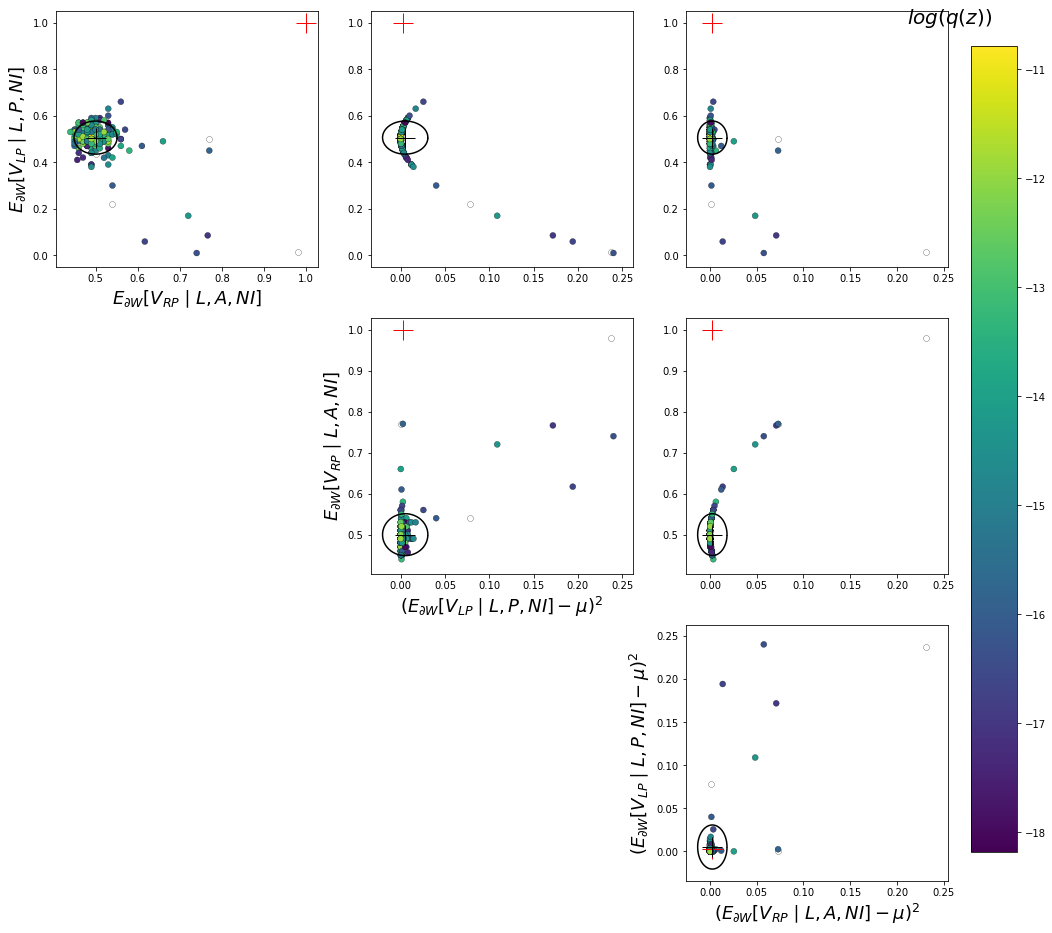

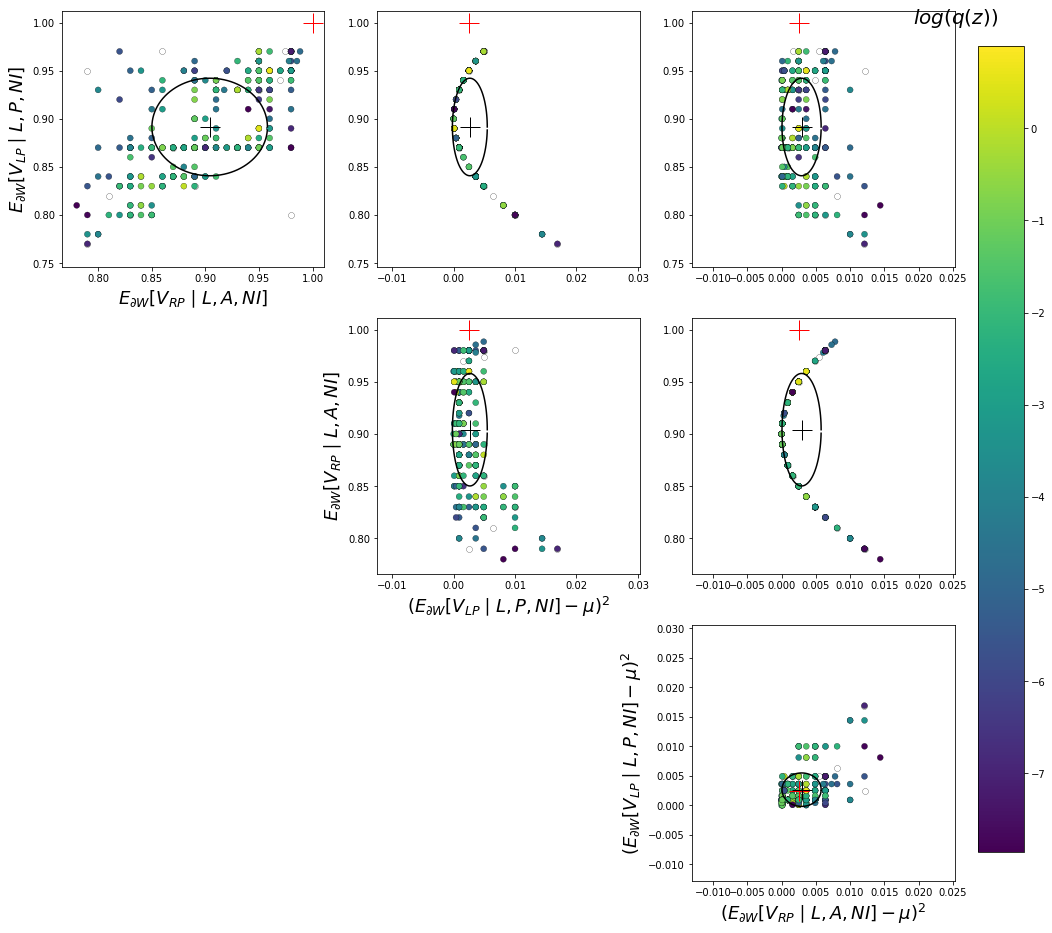

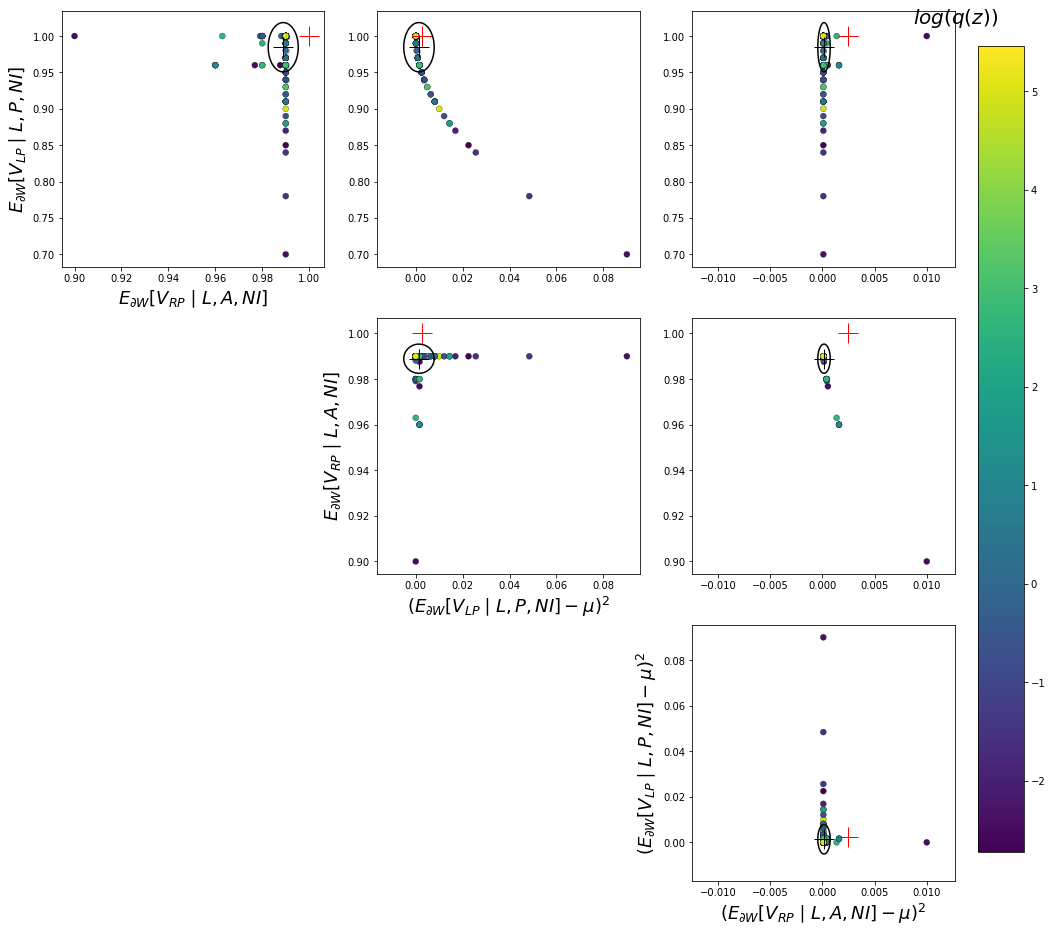

In [24]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
dists, cs, axs = dsn_pairplots(best_models, 'T_xs', system, system.num_suff_stats, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=ME_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=True, tri=True,
                      figsize=(16,16))


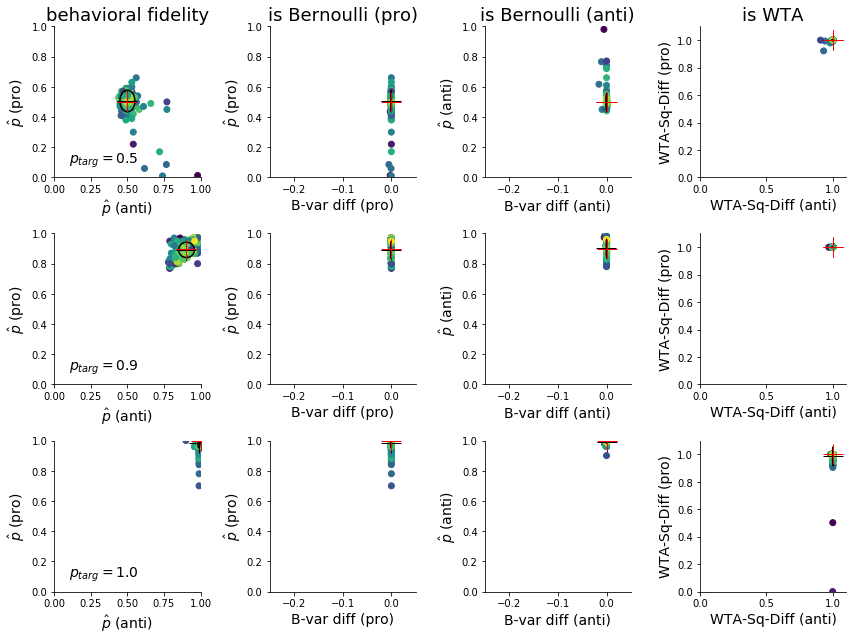

In [26]:
def plot_SC_behavior(T_xs, log_p_zs, ps):
    num_dists = len(T_xs)
    fontsize = 14
    fig, axs = plt.subplots(num_dists, 4, figsize=(12, num_dists*3))
    for i in range(num_dists):
        axs[i][0].scatter(T_xs[i][:,1], T_xs[i][:,0], c=cs[i])
        axs[i][0].set_xlim([0, 1])
        axs[i][0].set_ylim([0, 1])
        axs[i][0].set_xlabel(r'$\hat{p}$ (anti)', fontsize=fontsize)
        axs[i][0].set_ylabel(r'$\hat{p}$ (pro)', fontsize=fontsize)
        axs[i][0].text(0.1, 0.1, r'$p_{targ}=%.1f$' % ps[i], fontsize=fontsize)
        plot_var_ellipse(axs[i][0], T_xs[i][:,1], T_xs[i][:,0])
        axs[i][0].plot(ps[i], ps[i], c='r', marker="+", ms=20)
        
        axs[i][1].scatter(T_xs[i][:,4], T_xs[i][:,0], c=cs[i])
        axs[i][1].set_xlim([-0.25, 0.05])
        axs[i][1].set_ylim([0, 1])
        axs[i][1].set_xlabel('B-var diff (pro)', fontsize=fontsize)
        axs[i][1].set_ylabel(r'$\hat{p}$ (pro)', fontsize=fontsize)
        plot_var_ellipse(axs[i][1], T_xs[i][:,4], T_xs[i][:,0])
        axs[i][1].plot(0.0, ps[i], c='r', marker="+", ms=20)
        
        axs[i][2].scatter(T_xs[i][:,5], T_xs[i][:,1], c=cs[i])
        axs[i][2].set_xlim([-0.25, 0.05])
        axs[i][2].set_ylim([0, 1])
        axs[i][2].set_xlabel('B-var diff (anti)', fontsize=fontsize)
        axs[i][2].set_ylabel(r'$\hat{p}$ (anti)', fontsize=fontsize)
        plot_var_ellipse(axs[i][2], T_xs[i][:,5], T_xs[i][:,1])
        axs[i][2].plot(0.0, ps[i], c='r', marker="+", ms=20)
        
        axs[i][3].scatter(T_xs[i][:,7], T_xs[i][:,6], c=cs[i])
        axs[i][3].set_xlim([0, 1.1])
        axs[i][3].set_ylim([0, 1.1])
        axs[i][3].set_xlabel('WTA-Sq-Diff (anti)', fontsize=fontsize)
        axs[i][3].set_ylabel('WTA-Sq-Diff (pro)', fontsize=fontsize)
        plot_var_ellipse(axs[i][3], T_xs[i][:,7], T_xs[i][:,6])
        axs[i][3].plot(1.0, 1.0, c='r', marker="+", ms=20)
        
        for j in range(4):
            axs[i][j].spines['top'].set_visible(False)
            axs[i][j].spines['right'].set_visible(False)
            
    inc_font = 4
    axs[0][0].set_title('behavioral fidelity', fontsize=fontsize+inc_font)
    axs[0][1].set_title('is Bernoulli (pro)', fontsize=fontsize+inc_font)
    axs[0][2].set_title('is Bernoulli (anti)', fontsize=fontsize+inc_font)
    axs[0][3].set_title('is WTA', fontsize=fontsize+inc_font)
    
    plt.tight_layout()
    plt.show()
    return None

plot_SC_behavior(dists, cs, ps)